In [1]:
from pysme.linelist.vald import ValdFile
from pysme.sme import SME_Structure
from pysme.util import vac2air, air2vac
from pysme.solve import solve
from pysme.abund import Abund
from pysme import sme as SME
from pysme import util

from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import sys
import os

warnings.filterwarnings('ignore')

In [2]:
os.chdir('/home/fgran/iSpec/')
import ispec
sys.path.append('/home/fgran/iSpec/')

In [3]:
os.environ['NUMEXPR_MAX_THREADS'] = '80' #change this number using the correct number of cores/threads in jupyter.slurm

In [4]:
#Move to the correct directory: Pristine-UVES
os.chdir('/store/teams/cosmos/fgran/data/Pristine-UVES/')

In [5]:
#Prepare catalogue ingestion

In [6]:
uves = pd.read_csv('uves_p111_p112_pristinedr1_xgboost_logg.csv')

In [7]:
#pysme that only need to be executed once
linelist = ValdFile('linelist/3800-6800_long.lin')
# linelist = ValdFile('linelist/VALD_korg_linelist_3000_9000.lin', medium='air')
# linelist.wlcent = vac2air(linelist.wlcent, 'A')
print('Number of lines in the linelist: %d' %linelist.species.size)

delta_H_line = 10. #AA
delta_line = 1. #AA
wl_G_band = 4300 #AA
delta_G_band = 40. #AA

wl_Halpha_line = 6562.79 #AA
delta_Halpha = 10.0 #AA
wl_Hbeta_line = 4861.35 #AA
delta_Hbeta = 10.00 #AA

[2024-11-11 11:50:30,655] [INFO] [vald:loads:173]: Loading VALD file linelist/3800-6800_long.lin


INFO - Loading VALD file linelist/3800-6800_long.lin


[2024-11-11 11:50:32,619] [WARNING] [vald:parse_references:530]: Could not find citation key: LBT
[2024-11-11 11:50:32,620] [DEBUG] [vald:parse_references:531]: 'lbt'
[2024-11-11 11:50:32,621] [WARNING] [vald:parse_references:530]: Could not find citation key: TPSb
[2024-11-11 11:50:32,621] [DEBUG] [vald:parse_references:531]: 'tpsb'
[2024-11-11 11:50:32,622] [WARNING] [vald:parse_references:530]: Could not find citation key: TPSa
[2024-11-11 11:50:32,622] [DEBUG] [vald:parse_references:531]: 'tpsa'
[2024-11-11 11:50:32,623] [WARNING] [vald:parse_references:530]: Could not find citation key: NIST22
[2024-11-11 11:50:32,624] [DEBUG] [vald:parse_references:531]: 'nist22'
[2024-11-11 11:50:32,624] [WARNING] [vald:parse_references:530]: Could not find citation key: SNave
[2024-11-11 11:50:32,625] [DEBUG] [vald:parse_references:531]: 'snave'
[2024-11-11 11:50:32,625] [WARNING] [vald:parse_references:530]: Could not find citation key: SugCor
[2024-11-11 11:50:32,626] [DEBUG] [vald:parse_refe

WARNING - Could not find citation key: LBT
WARNING - Could not find citation key: TPSb
WARNING - Could not find citation key: TPSa
WARNING - Could not find citation key: NIST22
WARNING - Could not find citation key: SNave
WARNING - Could not find citation key: SugCor
WARNING - Could not find citation key: Kra2010
Number of lines in the linelist: 2902


In [8]:
wmin_blue = 4000 #AA
wmax_blue = 4500 #AA
wmin_red1 = 4730 #AA
wmax_red1 = 5700 #AA
wmin_red2 = 5850 #AA
wmax_red2 = 6800 #AA

In [9]:
linelist = linelist[((linelist.wlcent > wmin_blue) & (linelist.wlcent < wmax_blue) | \
                     (linelist.wlcent > wmin_red1) & (linelist.wlcent < wmax_red1) | \
                     (linelist.wlcent > wmin_red2) & (linelist.wlcent < wmax_red2))]

In [10]:
#Create solar scaled atmosphere with [alpha/Fe] = +0.4
solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

abund = solar.abund.pattern
abund['O'] = abund['O'] + 0.4
abund['Ne'] = abund['Ne'] + 0.4
abund['Mg'] = abund['Mg'] + 0.4
abund['Si'] = abund['Si'] + 0.4
abund['S'] = abund['S'] + 0.4
abund['Ar'] = abund['Ar'] + 0.4
abund['Ca'] = abund['Ca'] + 0.4
abund['Ti'] = abund['Ti'] + 0.4

In [11]:
elems_to_include = ['Fe 1', 'Fe 2', 'Mg 1', 'Ti 1', 'Ti 2', 'Ni 1', 'Ni 2']
linelist = linelist[np.asarray([True if elem in elems_to_include else False for elem in linelist.species])]

In [12]:
print(np.unique(linelist.species))
print('Nro de lineas', linelist.species.size)

['Fe 1' 'Fe 2' 'Mg 1' 'Ni 1' 'Ti 1' 'Ti 2']
Nro de lineas 809


In [13]:
def snr(wl, flux, central_lambda, delta_lambda):
    flux = flux[np.abs(wl - central_lambda) < delta_lambda]
    return np.median(flux) / (1.482602 / np.sqrt(6.0) * np.median(np.abs(2 * flux - np.roll(flux, 2) - np.roll(flux, -2))))

In [14]:
mask_cont = pd.read_csv('continuum_model/sme_cont_mask', sep=' ', names=['wl', 'mask_values'])

In [15]:
#SME parallel and init functions

In [16]:
def sme_init(wave, spec, uncs, teff, logg, monh, vmic, vmac, abund, vrad_flag, linelist, ipress, vrad_bounds, elems_to_include):

    #SME definitions
    sme = SME_Structure()

    sme.ipres, sme.iptype, sme.gam6, sme.h2broad = ipress, 'gauss', True, True
    sme.atmo.source, sme.atmo.method, sme.atmo.geom = 'marcs2012s_t2.0.sav', 'grid', 'SPH'

    sme.accxt, sme.accgt, sme.accft = tol, tol, tol
    sme.leastsquare3_ftol, sme.leastsquares_gtol, sme.leastsquares_xtol = tol, tol, tol
    sme.accwi, sme.accrt, sme.clim, sme.chirat = tol, tol, tol, tol
    sme.vrad_bounds = vrad_bounds

    # Redirect output to logs/RUN*/*.txt
    util.start_logging(log_file='logs/UVES_atm.txt', level='ERROR')

    sme.cscale_flag = 'constant'
    # sme.cscale = 1.0
    sme.cscale_type = 'mask'
    sme.fitresults.maxiter = 100

    sme.wave = wave
    sme.spec = spec
    sme.uncs = uncs

    # The mask values are: 0: bad pixel, 1: line pixel, 2: continuum pixel
    line_regions = mask_cont.mask_values.values
    ll_mask = np.zeros(linelist.species.size).astype(bool)
    
    for wline, mask_species in linelist[['wlcent', 'species']]:
        if mask_species in elems_to_include:
            idx_ = (sme.wave.data > wline-delta_line) & (sme.wave.data < wline+delta_line)
            line_regions[idx_] = 1
            
            ll_mask[(linelist.wlcent > wline-delta_line) & (linelist.wlcent < wline+delta_line)] = True
            continue
        
    for wline, mask_species in linelist[['wlcent', 'species']]:
        #Hydrogen lines
        if 'H 1' == mask_species:
            idx_ = (sme.wave.data > wline-delta_Halpha) & (sme.wave.data < wline+delta_Halpha)
            line_regions[idx_] = 0
    del idx_
    
    #G-band and CaHK regions
    # line_regions[(sme.wave.data > wl_G_band-delta_G_band) & (sme.wave.data < wl_G_band+delta_G_band)] = 0
    # line_regions[(sme.wave.data > wl_CaHK_band-delta_CaHK_band) & (sme.wave.data < wl_CaHK_band+delta_CaHK_band)] = 0
    # line_regions[sme.wave.data < 4000] = 0
    #Merge all the line_regions as int
    line_regions = line_regions.astype(int)
    line_regions[sme.spec.data == 0.0] = 0
    sme.mask = line_regions
    del line_regions

    sme.linelist = linelist[ll_mask]
    del ll_mask

    #Abundance scaling to create realistic synthetics
    sme.abund = abund
    #RV determination for each chip
    sme.vrad_flag = vrad_flag

    #input guesses from xgboost
    sme.teff = teff
    sme.logg = logg
    sme.monh = monh
    sme.vmic = vmic
    sme.vmac = vmac
    
    return sme

In [17]:
def sme_parallel(i, input_row, elems_to_include, vrad_flag, ipress, tol=1e-2):

    #Load data to create SME structures
    blue_spec = ispec.read_spectrum('norm_RV_corr/%s/blue_%s' %(input_row.run, input_row.blue_file))
    blue_spec.waveobs = blue_spec.waveobs * 10.
    blue_spec.err[blue_spec.err == 0.0] = 1.0
    red1_spec = ispec.read_spectrum('norm_RV_corr/%s/red1_%s' %(input_row.run, input_row.red_file))
    red1_spec.waveobs = red1_spec.waveobs * 10.
    red1_spec.err[red1_spec.err == 0.0] = 1.0
    red2_spec = ispec.read_spectrum('norm_RV_corr/%s/red2_%s' %(input_row.run, input_row.red_file))
    red2_spec.waveobs = red2_spec.waveobs * 10.
    red2_spec.err[red2_spec.err == 0.0] = 1.0

    wave = [blue_spec.waveobs[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)], 
            red1_spec.waveobs[(red1_spec.waveobs > wmin_red1) & (red1_spec.waveobs < wmax_red1)],
            red2_spec.waveobs[(red2_spec.waveobs > wmin_red2) & (red2_spec.waveobs < wmax_red2)]]
    spec = [blue_spec.flux[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)],
            red1_spec.flux[(red1_spec.waveobs > wmin_red1) & (red1_spec.waveobs < wmax_red1)],
            red2_spec.flux[(red2_spec.waveobs > wmin_red2) & (red2_spec.waveobs < wmax_red2)]]
    uncs = [1./blue_spec.err[(blue_spec.waveobs > wmin_blue) & (blue_spec.waveobs < wmax_blue)],
            1./red1_spec.err[(red1_spec.waveobs > wmin_red1) & (red1_spec.waveobs < wmax_red1)],
            1./red2_spec.err[(red2_spec.waveobs > wmin_red2) & (red2_spec.waveobs < wmax_red2)]]

    del blue_spec, red1_spec, red2_spec

    #input guesses from xgboost
    teff = input_row.teff_xgboost # np.random.normal(loc=input_row.teff_xgboost, scale=100.) #input_row.teff_xgboost #np.random.normal(loc=input_row.teff_xgboost, scale=100.)
    logg = input_row.logg_bc # np.random.normal(loc=input_row.logg_bc, scale=input_row.elogg_bc) #input_row.logg_bc #np.random.normal(loc=input_row.logg_bc, scale=0.1)
    monh = input_row.mh_xgboost  # np.random.normal(loc=input_row.mh_xgboost, scale=0.1) #input_row.mh_xgboost #np.random.normal(loc=input_row.mh_xgboost, scale=0.1)
    vmic = 1.5 # np.random.normal(loc=2.0, scale=0.10) #1.5 #np.random.normal(loc=2.0, scale=0.10)
    vmac = 4.5

    sme = sme_init(wave, spec, uncs, teff, logg, monh, vmic, vmac, abund, vrad_flag, linelist, ipress = ipress, vrad_bounds = (-5,5), elems_to_include = elems_to_include)
    del wave, spec, uncs

    snr_4130 = snr(sme.wave.data, sme.spec.data, 4130, 2.5)
    snr_4460 = snr(sme.wave.data, sme.spec.data, 4460, 2.5)
    snr_5150 = snr(sme.wave.data, sme.spec.data, 5150, 2.5)
    snr_6100 = snr(sme.wave.data, sme.spec.data, 6100, 2.5)
    snr_6700 = snr(sme.wave.data, sme.spec.data, 6700, 2.5)
    
    #NLTE
    # sme.nlte.set_nlte('Fe', 'nlte_Fe_ama51_Feb2022_pysme.grd')
    # sme.nlte.set_nlte('H', 'nlte_H_ama51_pysme.grd')
    # sme.nlte.set_nlte('Mg', 'marcs2012_Mg2016.grd')
    # sme.nlte.set_nlte('Ti', 'marcs2012s_t2.0_Ti.grd')
    
    #Do the heavy lifting with fix logg from distances+BC
    fitparameters = ['teff', 'monh', 'vmic', 'vmac']
    sme = solve(sme, fitparameters)

    teff, eteff_sme, eteff_fit = sme.teff, sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0]
    logg, elogg_sme, elogg_fit = input_row.logg_bc, input_row.elogg_bc, input_row.elogg_bc
    monh, emonh_sme, emonh_fit = sme.monh, sme.fitresults.uncertainties[1], sme.fitresults.fit_uncertainties[1]
    vmic, evmic_sme, evmic_fit = sme.vmic, sme.fitresults.uncertainties[2], sme.fitresults.fit_uncertainties[2]
    vmac, evmac_sme, evmac_fit = sme.vmac, sme.fitresults.uncertainties[3], sme.fitresults.fit_uncertainties[3]
    sme_vrad1, sme_vrad2, sme_vrad3 = sme.vrad

    sme.save('sme_save/UVES_atm_%s' %input_row.spec_id)
    del sme

    columns = ['spec_id', 'teff', 'eteff_sme', 'eteff_fit', 'logg', 'elogg_sme', 'elogg_fit', 
               'monh', 'emonh_sme', 'emonh_fit', 'vmic', 'evmic_sme', 'evmic_fit', 'vmac', 'evmac_sme', 'evmac_fit', 
               'sme_vrad1', 'sme_vrad2', 'sme_vrad3', 'snr_4030', 'snr_4460', 'snr_5150', 'snr_6100', 'snr_6700']
    data_to_write = np.vstack((input_row.spec_id, teff, eteff_sme, eteff_fit, logg, elogg_sme, elogg_fit,
                               monh, emonh_sme, emonh_fit, vmic, evmic_sme, evmic_fit, vmac, evmac_sme, evmac_fit, 
                               sme_vrad1, sme_vrad2, sme_vrad3, snr_4130, snr_4460, snr_5150, snr_6100, snr_6700)).T

    del teff, eteff_sme, eteff_fit, logg, elogg_sme, elogg_fit, monh, emonh_sme, emonh_fit, vmic, evmic_sme, evmic_fit, vmac, evmac_sme, evmac_fit
    del snr_4130, snr_4460, snr_5150, snr_6100, snr_6700

    pd.DataFrame(data=data_to_write, columns=columns).to_csv('tmp_atm/UVES_atm_%s.csv' %input_row.spec_id, index=False, header=False)
    del data_to_write

    return

In [18]:
vrad_flag = 'each'
ipress = 42000
tol = 1e-3

In [18]:
# sme = sme_parallel(0, uves.iloc[0], elems_to_include=elems_to_include, vrad_flag=vrad_flag, ipress=ipress, tol=tol)

In [19]:
%%time

#Single execution
Parallel(n_jobs=-1, verbose=5)(delayed(sme_parallel)(i, input_row, elems_to_include=elems_to_include, vrad_flag=vrad_flag, ipress=ipress, tol=tol) for i, input_row in uves.iterrows())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 75 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of 160 | elapsed:  7.3min remaining: 19.3min
[Parallel(n_jobs=-1)]: Done  77 out of 160 | elapsed:  9.8min remaining: 10.6min
[Parallel(n_jobs=-1)]: Done 110 out of 160 | elapsed: 12.9min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done 143 out of 160 | elapsed: 15.7min remaining:  1.9min


CPU times: user 1.1 s, sys: 679 ms, total: 1.78 s
Wall time: 20min 55s


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 20.9min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [20]:
# ['spec_id', 'teff', 'eteff_sme', 'eteff_fit', 'logg', 'elogg_sme', 'elogg_fit', 
#                'monh', 'emonh_sme', 'emonh_fit', 'vmic', 'evmic_sme', 'evmic_fit', 'vmac', 'evmac_sme', 'evmac_fit', 
#                'sme_vrad1', 'sme_vrad2', 'sme_vrad3', 'snr_4030', 'snr_4460', 'snr_5150', 'snr_6100', 'snr_6700']
os.system('cat tmp_atm/UVES_atm* > tmp_merged/UVES_atm.csv');

In [21]:
!sed -i '1i \spec_id,teff,eteff_sme,eteff_fit,logg,elogg_sme,elogg_fit,monh,emonh_sme,emonh_fit,vmic,evmic_sme,evmic_fit,vmac,evmac_sme,\
evmac_fit,sme_vrad1,sme_vrad2,sme_vrad3,snr_4030,snr_4460,snr_5150,snr_6100,snr_6700' tmp_merged/UVES_atm.csv

In [19]:
#Determine unc scaling comparing with xgboost

In [20]:
def estimate_uncertainties_nice(resid, deriv, percentile, percentile_sig_down, percentile_sig_up):
        """
        Estimate the uncertainties by fitting the cumulative distribution of
        derivative / uncertainties vs. residual / derivative
        with the generalized normal distribution and use the 68% percentile
        as the 1 sigma approximation for a normally distributed variable

        Parameters
        ----------
        unc : array of shape (n,)
            uncertainties
        resid : array of shape (n,)
            residuals of the least squares fit
        deriv : array of shape (n, p)
            derivatives (jacobian) of the least squares fit for each parameter

        Returns
        -------
        freep_unc : array of shape (p,)
            uncertainties for each free paramater, in the same order as self.parameter_names
        """

        nparameters = deriv.shape[1]
        freep_unc = np.zeros(nparameters)

        for i in range(nparameters):
            pder = deriv[:, i]
            #Change #1
            # idx = pder != 0
            idx = np.abs(pder) > np.percentile(np.abs(pder), percentile)
            idx &= np.isfinite(pder)

            if np.count_nonzero(idx) <= 5:
                logger.warning(
                    "Not enough data points with a suitable derivative "
                    "to determine the uncertainties"
                )
                continue
            # Sort pixels according to the change of the i
            # parameter needed to match the observations
            idx_sort = np.argsort(resid[idx] / pder[idx])
            ch_x = resid[idx][idx_sort] / pder[idx][idx_sort]
            # Weights of the individual pixels also sorted
            # uncertainties are already included in pder / unc[idx][idx_sort]
            ch_y = np.abs(pder[idx][idx_sort])
            # ch_y = np.abs(pder / unc[idx][idx_sort])
            # Cumulative weights
            ch_y = np.cumsum(ch_y)
            # Normalized cumulative weights
            ch_y /= ch_y[-1]

            # hmed = np.interp(0.5, ch_y, ch_x)
            interval = np.interp([percentile_sig_down, percentile_sig_up], ch_y, ch_x)
            sigma_estimate = (interval[1] - interval[0]) / 2.
            freep_unc[i] = sigma_estimate

        return freep_unc

In [21]:
#Andrae+2020: 0.10 dex in [M/H], 50K in Teff, and 0.08 dex in log g

In [22]:
from scipy.stats import norm

In [28]:
uves = pd.read_csv('uves_p111_p112_pristinedr1_xgboost_logg.csv')
uves = uves.merge(pd.read_csv('tmp_merged/UVES_atm.csv'), on='spec_id')

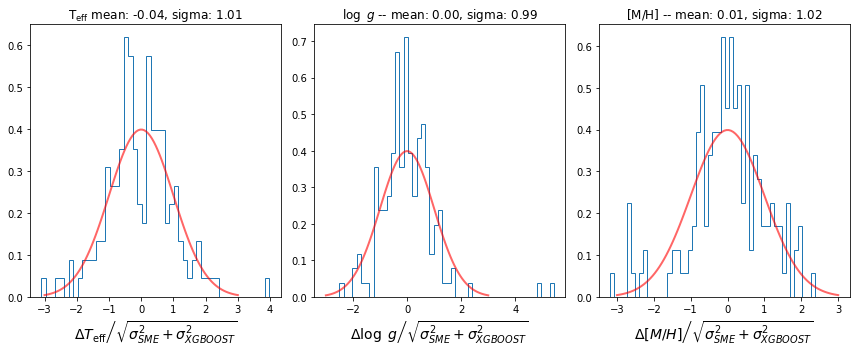

In [29]:
plt.figure(figsize=(12,5))

x = np.linspace(-3, 3, 100)

plt.subplot(1,3,1)
scale_factor_teff, shift_teff = 0.25, np.mean(uves.teff.values - uves.teff_xgboost.values)
q = (uves.teff.values - uves.teff_xgboost.values - shift_teff) / np.sqrt((scale_factor_teff * uves.eteff_sme.values)**2. + (50 * np.ones_like(uves.teff.values))**2.)
plt.hist(q, bins=50, histtype='step', density=True)
plt.plot(x, norm.pdf(x), color='r', lw=2, alpha=0.6)
plt.title(r'T$_{\rm eff}$ mean: %2.2f, sigma: %2.2f' %(np.mean(q), np.std(q)))
plt.xlabel(r'$\left. \Delta T_{\rm eff} \middle/ \sqrt{\sigma_{SME}^2 + \sigma_{XGBOOST}^2} \right.$', size=14)

plt.subplot(1,3,2)
scale_factor_logg, shift_logg = 1.9, np.mean(uves.logg.values - uves.logg_xgboost.values)
q = (uves.logg.values - uves.logg_xgboost.values - shift_logg) / np.sqrt((scale_factor_logg * uves.elogg_sme.values)**2. + (0.08 * np.ones_like(uves.logg.values))**2.)
plt.hist(q, bins=50, histtype='step', density=True)
plt.plot(x, norm.pdf(x), color='r', lw=2, alpha=0.6)
plt.title(r'$\log\ g$ -- mean: %2.2f, sigma: %2.2f' %(np.mean(q), np.std(q)))
plt.xlabel(r'$\left. \Delta \log\ g \middle/ \sqrt{\sigma_{SME}^2 + \sigma_{XGBOOST}^2} \right.$', size=14)

plt.subplot(1,3,3)
scale_factor_monh, shift_monh = 0.90, np.mean(uves.monh.values - uves.mh_xgboost.values)
q = (uves.monh.values - uves.mh_xgboost.values - shift_monh) / np.sqrt((scale_factor_monh * uves.emonh_sme.values)**2. + (0.1 * np.ones_like(uves.monh.values))**2.)
plt.hist(q, bins=50, histtype='step', density=True)
plt.plot(x, norm.pdf(x), color='r', lw=2, alpha=0.6)
plt.title(r'${\rm [M/H]}$ -- mean: %2.2f, sigma: %2.2f' %(np.mean(q), np.std(q)))
plt.xlabel(r'$\left. \Delta [M/H] \middle/ \sqrt{\sigma_{SME}^2 + \sigma_{XGBOOST}^2} \right.$', size=14)

plt.tight_layout()
plt.show()

In [30]:
print('SME overestimation of uncs:')
print('Teff: %2.2f' %scale_factor_teff)
print('logg: %2.2f' %scale_factor_logg)
print('[M/H]: %2.2f' %scale_factor_monh)

SME overestimation of uncs:
Teff: 0.25
logg: 1.90
[M/H]: 0.90


In [31]:
uves.eteff_sme = uves.eteff_sme.values * scale_factor_teff
uves.elogg_sme = uves.elogg_sme.values * scale_factor_logg
uves.emonh_sme = uves.emonh_sme.values * scale_factor_monh

In [32]:
uves.to_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs.csv', header=True, index=False)

In [16]:
#Uncs. scaling parameters
percentile, percentile_sig_down, percentile_sig_up = 85, 0.35, 0.65

In [17]:
eteff_sme, emonh_sme, evmic_sme, evmac_sme = np.empty_like(uves.spec_id.values), np.empty_like(uves.spec_id.values), np.empty_like(uves.spec_id.values), np.empty_like(uves.spec_id.values)

for i, sid in enumerate(uves.spec_id.values):

    sme = SME_Structure.load('sme_save/UVES_atm_%s.sme' %sid)

    #Re-scale uncs
    eteff_sme[i], emonh_sme[i], evmic_sme[i], evmac_sme[i] = estimate_uncertainties_nice(resid=sme.fitresults.residuals, deriv=sme.fitresults.derivative, 
                                              percentile=percentile, percentile_sig_down=percentile_sig_down, percentile_sig_up=percentile_sig_up)

[2024-10-31 11:45:18,084] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_1166634514845213568_3572891_000.sme
[2024-10-31 11:45:18,121] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_1172165023972931072_3573727_087.sme


INFO - Loading SME file sme_save/UVES_atm_1166634514845213568_3572891_000.sme
INFO - Loading SME file sme_save/UVES_atm_1172165023972931072_3573727_087.sme


[2024-10-31 11:45:18,557] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_1738069055902080768_3572805_001.sme


INFO - Loading SME file sme_save/UVES_atm_1738069055902080768_3572805_001.sme


[2024-10-31 11:45:18,798] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_1741229533355306496_3573222_036.sme


INFO - Loading SME file sme_save/UVES_atm_1741229533355306496_3573222_036.sme


[2024-10-31 11:45:19,136] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_1749801257286506880_3573721_089.sme


INFO - Loading SME file sme_save/UVES_atm_1749801257286506880_3573721_089.sme


[2024-10-31 11:45:19,730] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2378437233645989632_3573255_056.sme
[2024-10-31 11:45:19,866] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2386765901082612352_3573748_121.sme


INFO - Loading SME file sme_save/UVES_atm_2378437233645989632_3573255_056.sme
INFO - Loading SME file sme_save/UVES_atm_2386765901082612352_3573748_121.sme


[2024-10-31 11:45:19,993] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2541284393302759296_3708442_129.sme


INFO - Loading SME file sme_save/UVES_atm_2541284393302759296_3708442_129.sme


[2024-10-31 11:45:20,394] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2599833353121973248_3573736_122.sme
[2024-10-31 11:45:20,498] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2569615268897126016_3708424_127.sme


INFO - Loading SME file sme_save/UVES_atm_2599833353121973248_3573736_122.sme
INFO - Loading SME file sme_save/UVES_atm_2569615268897126016_3708424_127.sme


[2024-10-31 11:45:20,613] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2629976155159613312_3573193_053.sme


INFO - Loading SME file sme_save/UVES_atm_2629976155159613312_3573193_053.sme


[2024-10-31 11:45:21,019] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2618359849171681280_3576286_085.sme


INFO - Loading SME file sme_save/UVES_atm_2618359849171681280_3576286_085.sme


[2024-10-31 11:45:21,450] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2668140817939519744_3576352_067.sme
[2024-10-31 11:45:21,552] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2666382767566459264_3573733_102.sme


INFO - Loading SME file sme_save/UVES_atm_2668140817939519744_3576352_067.sme
INFO - Loading SME file sme_save/UVES_atm_2666382767566459264_3573733_102.sme


[2024-10-31 11:45:21,652] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2694284013287934208_3572882_005.sme


INFO - Loading SME file sme_save/UVES_atm_2694284013287934208_3572882_005.sme


[2024-10-31 11:45:22,050] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2686591069730583936_3576322_066.sme


INFO - Loading SME file sme_save/UVES_atm_2686591069730583936_3576322_066.sme


[2024-10-31 11:45:22,486] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2706817140174260224_3576298_070.sme


INFO - Loading SME file sme_save/UVES_atm_2706817140174260224_3576298_070.sme


[2024-10-31 11:45:22,754] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2745948518489568000_3708445_130.sme


INFO - Loading SME file sme_save/UVES_atm_2745948518489568000_3708445_130.sme


[2024-10-31 11:45:23,059] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2747167636367013632_3708433_128.sme
[2024-10-31 11:45:23,147] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2882976353396129408_3708481_137.sme


INFO - Loading SME file sme_save/UVES_atm_2747167636367013632_3708433_128.sme
INFO - Loading SME file sme_save/UVES_atm_2882976353396129408_3708481_137.sme


[2024-10-31 11:45:23,263] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2882976353396129408_3708481_142.sme
[2024-10-31 11:45:23,342] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2900487695273194880_3708421_134.sme


INFO - Loading SME file sme_save/UVES_atm_2882976353396129408_3708481_142.sme
INFO - Loading SME file sme_save/UVES_atm_2900487695273194880_3708421_134.sme


[2024-10-31 11:45:23,681] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2967216093892060928_3708490_144.sme
[2024-10-31 11:45:23,805] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_2970270979572570240_3708418_139.sme


INFO - Loading SME file sme_save/UVES_atm_2967216093892060928_3708490_144.sme
INFO - Loading SME file sme_save/UVES_atm_2970270979572570240_3708418_139.sme


[2024-10-31 11:45:23,915] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3067753616067185024_3708457_145.sme
[2024-10-31 11:45:24,006] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3178512679373155712_3708475_133.sme


INFO - Loading SME file sme_save/UVES_atm_3067753616067185024_3708457_145.sme
INFO - Loading SME file sme_save/UVES_atm_3178512679373155712_3708475_133.sme


[2024-10-31 11:45:24,540] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3184578612007287680_3708454_141.sme
[2024-10-31 11:45:24,665] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3185283059661339648_3708448_138.sme


INFO - Loading SME file sme_save/UVES_atm_3184578612007287680_3708454_141.sme
INFO - Loading SME file sme_save/UVES_atm_3185283059661339648_3708448_138.sme


[2024-10-31 11:45:24,772] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3474451177494568320_3576292_064.sme
[2024-10-31 11:45:24,914] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3473880535256883328_3708463_148.sme


INFO - Loading SME file sme_save/UVES_atm_3474451177494568320_3576292_064.sme
INFO - Loading SME file sme_save/UVES_atm_3473880535256883328_3708463_148.sme


[2024-10-31 11:45:25,208] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3492757569356904320_3572799_018.sme
[2024-10-31 11:45:25,305] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3497335970134475136_3708451_154.sme


INFO - Loading SME file sme_save/UVES_atm_3492757569356904320_3572799_018.sme
INFO - Loading SME file sme_save/UVES_atm_3497335970134475136_3708451_154.sme


[2024-10-31 11:45:25,422] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3513718345495642368_3573231_045.sme
[2024-10-31 11:45:25,524] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3523787024442853504_3576331_058.sme


INFO - Loading SME file sme_save/UVES_atm_3513718345495642368_3573231_045.sme
INFO - Loading SME file sme_save/UVES_atm_3523787024442853504_3576331_058.sme


[2024-10-31 11:45:25,652] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3532952961394037376_3572888_007.sme
[2024-10-31 11:45:25,764] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3543785319887452800_3572787_023.sme


INFO - Loading SME file sme_save/UVES_atm_3532952961394037376_3572888_007.sme
INFO - Loading SME file sme_save/UVES_atm_3543785319887452800_3572787_023.sme


[2024-10-31 11:45:25,870] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3543860498994891008_3573730_094.sme
[2024-10-31 11:45:25,972] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3549787824444153856_3708439_152.sme
[2024-10-31 11:45:26,069] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3572437218517370240_3573679_095.sme


INFO - Loading SME file sme_save/UVES_atm_3543860498994891008_3573730_094.sme
INFO - Loading SME file sme_save/UVES_atm_3549787824444153856_3708439_152.sme
INFO - Loading SME file sme_save/UVES_atm_3572437218517370240_3573679_095.sme


[2024-10-31 11:45:26,286] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3606188789515275136_3572879_020.sme
[2024-10-31 11:45:26,391] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3598383734427539840_3576364_061.sme


INFO - Loading SME file sme_save/UVES_atm_3606188789515275136_3572879_020.sme
INFO - Loading SME file sme_save/UVES_atm_3598383734427539840_3576364_061.sme


[2024-10-31 11:45:26,799] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3608416056475856512_3708499_157.sme


INFO - Loading SME file sme_save/UVES_atm_3608416056475856512_3708499_157.sme


[2024-10-31 11:45:27,502] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3665739129549287808_3573703_091.sme


INFO - Loading SME file sme_save/UVES_atm_3665739129549287808_3573703_091.sme


[2024-10-31 11:45:27,813] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3708428046455751680_3708469_153.sme


INFO - Loading SME file sme_save/UVES_atm_3708428046455751680_3708469_153.sme


[2024-10-31 11:45:28,040] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3725429210639578752_3708502_158.sme
[2024-10-31 11:45:28,158] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3818459160048340352_3573243_047.sme


INFO - Loading SME file sme_save/UVES_atm_3725429210639578752_3708502_158.sme
INFO - Loading SME file sme_save/UVES_atm_3818459160048340352_3573243_047.sme


[2024-10-31 11:45:28,355] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3822507802379684608_3576289_059.sme


INFO - Loading SME file sme_save/UVES_atm_3822507802379684608_3576289_059.sme


[2024-10-31 11:45:28,791] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3833089781458744960_3708478_146.sme
[2024-10-31 11:45:28,970] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3864303022490267136_3572840_010.sme


INFO - Loading SME file sme_save/UVES_atm_3833089781458744960_3708478_146.sme
INFO - Loading SME file sme_save/UVES_atm_3864303022490267136_3572840_010.sme


[2024-10-31 11:45:29,063] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3874671039183974272_3573246_039.sme


INFO - Loading SME file sme_save/UVES_atm_3874671039183974272_3573246_039.sme


[2024-10-31 11:45:29,681] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3892663864073428480_3576361_060.sme
[2024-10-31 11:45:29,764] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3876856013600995968_3708496_151.sme


INFO - Loading SME file sme_save/UVES_atm_3892663864073428480_3576361_060.sme
INFO - Loading SME file sme_save/UVES_atm_3876856013600995968_3708496_151.sme


[2024-10-31 11:45:30,098] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_3910233647567741056_3573216_038.sme


INFO - Loading SME file sme_save/UVES_atm_3910233647567741056_3573216_038.sme


[2024-10-31 11:45:30,519] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_4411228560308157184_3572825_009.sme
[2024-10-31 11:45:30,673] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_4423944137401740416_3572843_008.sme


INFO - Loading SME file sme_save/UVES_atm_4411228560308157184_3572825_009.sme
INFO - Loading SME file sme_save/UVES_atm_4423944137401740416_3572843_008.sme


[2024-10-31 11:45:30,815] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_4441762925923597184_3573225_035.sme
[2024-10-31 11:45:30,946] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_4433115644928113792_3573715_090.sme


INFO - Loading SME file sme_save/UVES_atm_4441762925923597184_3573225_035.sme
INFO - Loading SME file sme_save/UVES_atm_4433115644928113792_3573715_090.sme


[2024-10-31 11:45:31,152] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_4439777345364165376_3573751_086.sme


INFO - Loading SME file sme_save/UVES_atm_4439777345364165376_3573751_086.sme


[2024-10-31 11:45:31,521] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_4450279330676186368_3576301_057.sme


INFO - Loading SME file sme_save/UVES_atm_4450279330676186368_3576301_057.sme


[2024-10-31 11:45:32,043] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_4752197836317724160_3704064_123.sme


INFO - Loading SME file sme_save/UVES_atm_4752197836317724160_3704064_123.sme


[2024-10-31 11:45:32,450] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_4757476003231981952_3708427_136.sme


INFO - Loading SME file sme_save/UVES_atm_4757476003231981952_3708427_136.sme


[2024-10-31 11:45:32,775] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_4757476003231981952_3708427_140.sme


INFO - Loading SME file sme_save/UVES_atm_4757476003231981952_3708427_140.sme


[2024-10-31 11:45:33,086] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_4854289415101796608_3708430_135.sme


INFO - Loading SME file sme_save/UVES_atm_4854289415101796608_3708430_135.sme


[2024-10-31 11:45:33,400] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_4901776016635135488_3708493_124.sme
[2024-10-31 11:45:33,593] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_4905666294932720000_3708505_125.sme


INFO - Loading SME file sme_save/UVES_atm_4901776016635135488_3708493_124.sme
INFO - Loading SME file sme_save/UVES_atm_4905666294932720000_3708505_125.sme


[2024-10-31 11:45:33,834] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_4913520175210033152_3708460_131.sme
[2024-10-31 11:45:33,926] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_4954240794503614720_3704133_132.sme


INFO - Loading SME file sme_save/UVES_atm_4913520175210033152_3708460_131.sme
INFO - Loading SME file sme_save/UVES_atm_4954240794503614720_3704133_132.sme


[2024-10-31 11:45:34,439] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_5050991770433282688_3704139_126.sme
[2024-10-31 11:45:34,620] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_5454289027730222848_3708466_149.sme


INFO - Loading SME file sme_save/UVES_atm_5050991770433282688_3704139_126.sme
INFO - Loading SME file sme_save/UVES_atm_5454289027730222848_3708466_149.sme


[2024-10-31 11:45:34,717] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_5584165230990237824_3708487_143.sme
[2024-10-31 11:45:34,830] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_5735381717990313216_3572855_004.sme


INFO - Loading SME file sme_save/UVES_atm_5584165230990237824_3708487_143.sme
INFO - Loading SME file sme_save/UVES_atm_5735381717990313216_3572855_004.sme


[2024-10-31 11:45:34,935] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_5736440096715771136_3573724_093.sme
[2024-10-31 11:45:35,031] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_5755996908175855232_3572793_003.sme


INFO - Loading SME file sme_save/UVES_atm_5736440096715771136_3573724_093.sme
INFO - Loading SME file sme_save/UVES_atm_5755996908175855232_3572793_003.sme


[2024-10-31 11:45:35,143] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_5803007691756413056_3572867_002.sme
[2024-10-31 11:45:35,285] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_5805316292518188672_3573237_034.sme


INFO - Loading SME file sme_save/UVES_atm_5803007691756413056_3572867_002.sme
INFO - Loading SME file sme_save/UVES_atm_5805316292518188672_3573237_034.sme


[2024-10-31 11:45:35,427] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_5805489018923755136_3573688_101.sme


INFO - Loading SME file sme_save/UVES_atm_5805489018923755136_3573688_101.sme


[2024-10-31 11:45:35,726] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6107795579151078528_3573219_042.sme
[2024-10-31 11:45:35,814] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6100873608000306176_3576355_077.sme


INFO - Loading SME file sme_save/UVES_atm_6107795579151078528_3573219_042.sme
INFO - Loading SME file sme_save/UVES_atm_6100873608000306176_3576355_077.sme


[2024-10-31 11:45:35,935] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6119043621766704640_3576334_073.sme
[2024-10-31 11:45:36,053] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6133678941862384768_3576343_063.sme


INFO - Loading SME file sme_save/UVES_atm_6119043621766704640_3576334_073.sme
INFO - Loading SME file sme_save/UVES_atm_6133678941862384768_3576343_063.sme


[2024-10-31 11:45:36,143] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6150224495918526848_3573252_041.sme


INFO - Loading SME file sme_save/UVES_atm_6150224495918526848_3573252_041.sme


[2024-10-31 11:45:36,379] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6158271340483740288_3708436_147.sme
[2024-10-31 11:45:36,478] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6158820275960197376_3708484_156.sme


INFO - Loading SME file sme_save/UVES_atm_6158271340483740288_3708436_147.sme
INFO - Loading SME file sme_save/UVES_atm_6158820275960197376_3708484_156.sme


[2024-10-31 11:45:36,614] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6167441439259305088_3573234_046.sme
[2024-10-31 11:45:36,779] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6180986292937221120_3708472_155.sme


INFO - Loading SME file sme_save/UVES_atm_6167441439259305088_3573234_046.sme
INFO - Loading SME file sme_save/UVES_atm_6180986292937221120_3708472_155.sme


[2024-10-31 11:45:36,909] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6180986292937221120_3708472_159.sme


INFO - Loading SME file sme_save/UVES_atm_6180986292937221120_3708472_159.sme


[2024-10-31 11:45:37,394] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6223323778439145216_3572846_011.sme


INFO - Loading SME file sme_save/UVES_atm_6223323778439145216_3572846_011.sme


[2024-10-31 11:45:37,744] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6279500095244393728_3573718_120.sme


INFO - Loading SME file sme_save/UVES_atm_6279500095244393728_3573718_120.sme


[2024-10-31 11:45:37,959] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6292504156704893696_3704136_150.sme
[2024-10-31 11:45:38,109] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6324010937276922880_3572861_025.sme


INFO - Loading SME file sme_save/UVES_atm_6292504156704893696_3704136_150.sme
INFO - Loading SME file sme_save/UVES_atm_6324010937276922880_3572861_025.sme


[2024-10-31 11:45:38,430] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6312184792070759552_3573694_092.sme
[2024-10-31 11:45:38,588] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6354182945092770176_3572894_033.sme


INFO - Loading SME file sme_save/UVES_atm_6312184792070759552_3573694_092.sme
INFO - Loading SME file sme_save/UVES_atm_6354182945092770176_3572894_033.sme


[2024-10-31 11:45:38,729] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6373464839991607552_3572813_015.sme
[2024-10-31 11:45:38,844] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6392134513070641408_3572837_021.sme


INFO - Loading SME file sme_save/UVES_atm_6373464839991607552_3572813_015.sme
INFO - Loading SME file sme_save/UVES_atm_6392134513070641408_3572837_021.sme


[2024-10-31 11:45:38,948] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6425379106130933376_3573700_088.sme
[2024-10-31 11:45:39,057] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6441312919402521728_3573682_097.sme


INFO - Loading SME file sme_save/UVES_atm_6425379106130933376_3573700_088.sme
INFO - Loading SME file sme_save/UVES_atm_6441312919402521728_3573682_097.sme


[2024-10-31 11:45:39,230] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6445544385605809152_3573258_043.sme
[2024-10-31 11:45:39,411] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6451871117247012864_3576367_065.sme


INFO - Loading SME file sme_save/UVES_atm_6445544385605809152_3573258_043.sme
INFO - Loading SME file sme_save/UVES_atm_6451871117247012864_3576367_065.sme


[2024-10-31 11:45:39,523] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6445869192509584640_3573664_098.sme
[2024-10-31 11:45:39,664] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6459090785472607744_3572852_019.sme


INFO - Loading SME file sme_save/UVES_atm_6445869192509584640_3573664_098.sme
INFO - Loading SME file sme_save/UVES_atm_6459090785472607744_3572852_019.sme


[2024-10-31 11:45:40,115] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6456829704234138880_3573712_110.sme
[2024-10-31 11:45:40,257] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6456829704234138880_3573712_113.sme


INFO - Loading SME file sme_save/UVES_atm_6456829704234138880_3573712_110.sme
INFO - Loading SME file sme_save/UVES_atm_6456829704234138880_3573712_113.sme


[2024-10-31 11:45:40,364] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6473118900280458240_3573196_049.sme
[2024-10-31 11:45:40,484] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6488378098744387968_3576337_082.sme


INFO - Loading SME file sme_save/UVES_atm_6473118900280458240_3573196_049.sme
INFO - Loading SME file sme_save/UVES_atm_6488378098744387968_3576337_082.sme


[2024-10-31 11:45:40,583] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6517965235093153920_3572819_016.sme
[2024-10-31 11:45:40,691] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6520905878946665344_3573199_055.sme


INFO - Loading SME file sme_save/UVES_atm_6517965235093153920_3572819_016.sme
INFO - Loading SME file sme_save/UVES_atm_6520905878946665344_3573199_055.sme


[2024-10-31 11:45:40,837] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6523938984849548032_3573742_119.sme
[2024-10-31 11:45:40,978] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6572630135729345280_3572858_032.sme


INFO - Loading SME file sme_save/UVES_atm_6523938984849548032_3573742_119.sme
INFO - Loading SME file sme_save/UVES_atm_6572630135729345280_3572858_032.sme


[2024-10-31 11:45:41,123] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6575733885254308096_3572876_031.sme
[2024-10-31 11:45:41,205] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6565897654232474240_3576319_074.sme


INFO - Loading SME file sme_save/UVES_atm_6575733885254308096_3572876_031.sme
INFO - Loading SME file sme_save/UVES_atm_6565897654232474240_3576319_074.sme


[2024-10-31 11:45:41,330] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6631364397619544448_3572790_006.sme


INFO - Loading SME file sme_save/UVES_atm_6631364397619544448_3572790_006.sme


[2024-10-31 11:45:41,615] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6629073801361978752_3576325_072.sme


INFO - Loading SME file sme_save/UVES_atm_6629073801361978752_3576325_072.sme


[2024-10-31 11:45:41,840] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6636060098245932672_3573249_037.sme


INFO - Loading SME file sme_save/UVES_atm_6636060098245932672_3573249_037.sme


[2024-10-31 11:45:42,176] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6636060098245932672_3573249_040.sme
[2024-10-31 11:45:42,282] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6638071689128024960_3573709_109.sme


INFO - Loading SME file sme_save/UVES_atm_6636060098245932672_3573249_040.sme
INFO - Loading SME file sme_save/UVES_atm_6638071689128024960_3573709_109.sme


[2024-10-31 11:45:42,463] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6638289946484861184_3573754_112.sme
[2024-10-31 11:45:42,552] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6638289946484861184_3573754_117.sme
[2024-10-31 11:45:42,663] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6654901157699273600_3573661_096.sme


INFO - Loading SME file sme_save/UVES_atm_6638289946484861184_3573754_112.sme
INFO - Loading SME file sme_save/UVES_atm_6638289946484861184_3573754_117.sme
INFO - Loading SME file sme_save/UVES_atm_6654901157699273600_3573661_096.sme


[2024-10-31 11:45:43,032] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6661076122378750208_3572802_012.sme
[2024-10-31 11:45:43,169] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6662769232846184064_3573676_100.sme


INFO - Loading SME file sme_save/UVES_atm_6661076122378750208_3572802_012.sme
INFO - Loading SME file sme_save/UVES_atm_6662769232846184064_3573676_100.sme


[2024-10-31 11:45:43,302] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6667107184173771648_3572870_026.sme
[2024-10-31 11:45:43,425] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6676351809220383872_3573210_050.sme


INFO - Loading SME file sme_save/UVES_atm_6667107184173771648_3572870_026.sme
INFO - Loading SME file sme_save/UVES_atm_6676351809220383872_3573210_050.sme


[2024-10-31 11:45:43,514] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6678142192107202048_3573207_052.sme
[2024-10-31 11:45:43,616] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6691238917488008576_3573745_116.sme


INFO - Loading SME file sme_save/UVES_atm_6678142192107202048_3573207_052.sme
INFO - Loading SME file sme_save/UVES_atm_6691238917488008576_3573745_116.sme


[2024-10-31 11:45:43,722] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6694136650318351488_3573673_103.sme
[2024-10-31 11:45:43,909] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6702358209860679168_3573213_044.sme


INFO - Loading SME file sme_save/UVES_atm_6694136650318351488_3573673_103.sme
INFO - Loading SME file sme_save/UVES_atm_6702358209860679168_3573213_044.sme


[2024-10-31 11:45:44,034] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6704867982593521536_3573202_048.sme
[2024-10-31 11:45:44,158] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6705676437173390848_3576283_076.sme


INFO - Loading SME file sme_save/UVES_atm_6704867982593521536_3573202_048.sme
INFO - Loading SME file sme_save/UVES_atm_6705676437173390848_3576283_076.sme


[2024-10-31 11:45:44,454] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6706871675035800448_3576346_075.sme


INFO - Loading SME file sme_save/UVES_atm_6706871675035800448_3576346_075.sme


[2024-10-31 11:45:44,710] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6710975288644549760_3573739_108.sme


INFO - Loading SME file sme_save/UVES_atm_6710975288644549760_3573739_108.sme


[2024-10-31 11:45:44,995] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6710975288644549760_3573739_114.sme


INFO - Loading SME file sme_save/UVES_atm_6710975288644549760_3573739_114.sme


[2024-10-31 11:45:45,669] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6715513046151135360_3576349_069.sme


INFO - Loading SME file sme_save/UVES_atm_6715513046151135360_3576349_069.sme


[2024-10-31 11:45:46,048] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6723486463964965120_3576295_071.sme


INFO - Loading SME file sme_save/UVES_atm_6723486463964965120_3576295_071.sme


[2024-10-31 11:45:46,410] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6728409939582968192_3572831_014.sme
[2024-10-31 11:45:46,505] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6730560614395195392_3573667_104.sme


INFO - Loading SME file sme_save/UVES_atm_6728409939582968192_3572831_014.sme
INFO - Loading SME file sme_save/UVES_atm_6730560614395195392_3573667_104.sme


[2024-10-31 11:45:46,760] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6730560614395195392_3573667_107.sme


INFO - Loading SME file sme_save/UVES_atm_6730560614395195392_3573667_107.sme


[2024-10-31 11:45:46,997] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6758905508758832640_3572885_013.sme


INFO - Loading SME file sme_save/UVES_atm_6758905508758832640_3572885_013.sme


[2024-10-31 11:45:47,281] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6758510681005269632_3573228_051.sme
[2024-10-31 11:45:47,375] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6767541317898238976_3572828_022.sme


INFO - Loading SME file sme_save/UVES_atm_6758510681005269632_3573228_051.sme
INFO - Loading SME file sme_save/UVES_atm_6767541317898238976_3572828_022.sme


[2024-10-31 11:45:47,492] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6776164134760319488_3576358_062.sme


INFO - Loading SME file sme_save/UVES_atm_6776164134760319488_3576358_062.sme


[2024-10-31 11:45:48,223] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6782613904328340096_3572873_030.sme


INFO - Loading SME file sme_save/UVES_atm_6782613904328340096_3572873_030.sme


[2024-10-31 11:45:48,861] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6796908723721277568_3572808_017.sme


INFO - Loading SME file sme_save/UVES_atm_6796908723721277568_3572808_017.sme


[2024-10-31 11:45:49,234] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6796745957342984576_3576304_081.sme
[2024-10-31 11:45:49,353] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6797837428793125760_3573685_105.sme


INFO - Loading SME file sme_save/UVES_atm_6796745957342984576_3576304_081.sme
INFO - Loading SME file sme_save/UVES_atm_6797837428793125760_3573685_105.sme


[2024-10-31 11:45:49,489] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6807184278357672576_3576340_078.sme
[2024-10-31 11:45:49,594] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6833339632756724992_3573697_118.sme


INFO - Loading SME file sme_save/UVES_atm_6807184278357672576_3576340_078.sme
INFO - Loading SME file sme_save/UVES_atm_6833339632756724992_3573697_118.sme


[2024-10-31 11:45:49,710] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6844413467195214720_3572816_028.sme
[2024-10-31 11:45:49,838] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6846461582481204096_3572822_024.sme


INFO - Loading SME file sme_save/UVES_atm_6844413467195214720_3572816_028.sme
INFO - Loading SME file sme_save/UVES_atm_6846461582481204096_3572822_024.sme


[2024-10-31 11:45:50,309] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6854445926685734400_3572834_027.sme


INFO - Loading SME file sme_save/UVES_atm_6854445926685734400_3572834_027.sme


[2024-10-31 11:45:50,791] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6859284155805054848_3573658_099.sme
[2024-10-31 11:45:50,924] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6859555838257273600_3573691_106.sme


INFO - Loading SME file sme_save/UVES_atm_6859284155805054848_3573658_099.sme
INFO - Loading SME file sme_save/UVES_atm_6859555838257273600_3573691_106.sme


[2024-10-31 11:45:51,250] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6859555838257273600_3573691_115.sme
[2024-10-31 11:45:51,353] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6862950683484751616_3572796_029.sme


INFO - Loading SME file sme_save/UVES_atm_6859555838257273600_3573691_115.sme
INFO - Loading SME file sme_save/UVES_atm_6862950683484751616_3572796_029.sme


[2024-10-31 11:45:51,700] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6863375296834450304_3576316_083.sme


INFO - Loading SME file sme_save/UVES_atm_6863375296834450304_3576316_083.sme


[2024-10-31 11:45:52,202] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6873331791241472768_3576328_080.sme
[2024-10-31 11:45:52,374] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6881847646233384704_3573240_054.sme


INFO - Loading SME file sme_save/UVES_atm_6873331791241472768_3576328_080.sme
INFO - Loading SME file sme_save/UVES_atm_6881847646233384704_3573240_054.sme


[2024-10-31 11:45:52,482] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6874512834227642624_3576313_079.sme
[2024-10-31 11:45:52,609] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6887223673977641984_3573670_111.sme


INFO - Loading SME file sme_save/UVES_atm_6874512834227642624_3576313_079.sme
INFO - Loading SME file sme_save/UVES_atm_6887223673977641984_3573670_111.sme


[2024-10-31 11:45:52,735] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6901832159125681408_3576307_084.sme


INFO - Loading SME file sme_save/UVES_atm_6901832159125681408_3576307_084.sme


[2024-10-31 11:45:52,997] [INFO] [sme:load:839]: Loading SME file sme_save/UVES_atm_6913266534594667904_3576310_068.sme


INFO - Loading SME file sme_save/UVES_atm_6913266534594667904_3576310_068.sme


In [107]:
# percentile, percentile_sig_down, percentile_sig_up = 85, 0.20, 0.80


# for (percentile, percentile_sig_down, percentile_sig_up) in np.vstack(([70,70,70,80,80,80,85,85,85,90,90,90], [0.15, 0.25, 0.35, 0.15, 0.25, 0.35, 0.15, 0.25, 0.35, 0.15, 0.25, 0.35], 
#                                                                        [0.85, 0.75, 0.65,0.85, 0.75, 0.65, 0.85, 0.75, 0.65, 0.85, 0.75, 0.65])).T:

#     eteff_sme, emonh_sme, evmic_sme, evmac_sme = np.empty_like(uves.spec_id.values), np.empty_like(uves.spec_id.values), np.empty_like(uves.spec_id.values), np.empty_like(uves.spec_id.values)
#     util.start_logging(log_file='logs/UVES_atm.txt', level='ERROR')
#     for i, sid in enumerate(uves.spec_id.values):
    
#         sme = SME_Structure.load('sme_save/UVES_atm_%s.sme' %sid)
    
#         #Re-scale uncs
#         eteff_sme[i], emonh_sme[i], evmic_sme[i], evmac_sme[i] = estimate_uncertainties_nice(resid=sme.fitresults.residuals, deriv=sme.fitresults.derivative, 
#                                                   percentile=percentile, percentile_sig_down=percentile_sig_down, percentile_sig_up=percentile_sig_up)

#     shift_teff, shift_monh = np.mean(uves.teff.values - uves.teff_xgboost.values), np.mean(uves.monh.values - uves.mh_xgboost.values)
#     qt = (uves.teff.values - uves.teff_xgboost.values - shift_teff) / np.sqrt(eteff_sme.astype(float)**2. + (50 * np.ones_like(uves.teff.values))**2.)
#     qm = (uves.monh.values - uves.mh_xgboost.values - shift_monh) / np.sqrt(emonh_sme.astype(float)**2. + (0.1 * np.ones_like(uves.monh.values))**2.)
#     print('%d %1.2f %1.2f -- Teff: %2.2f +- %1.2f -- [M/H]: %2.2f +- %1.2f' %(percentile, percentile_sig_down, percentile_sig_up, np.mean(qt), np.std(qt), np.mean(qm), np.std(qm)))

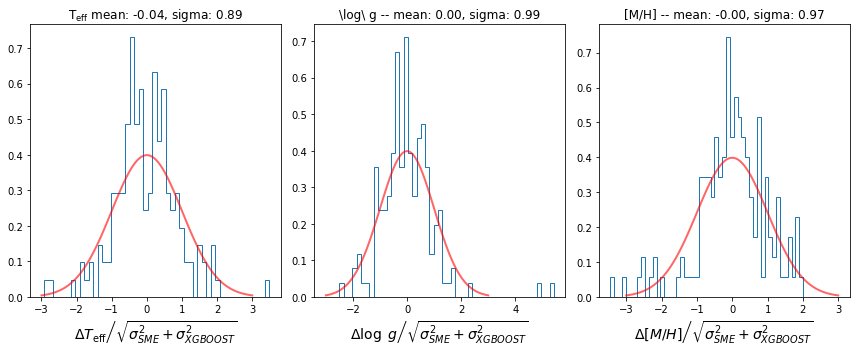

In [18]:
plt.figure(figsize=(12,5))

x = np.linspace(-3, 3, 100)

plt.subplot(1,3,1)
scale_factor_teff, shift_teff = 1., np.mean(uves.teff.values - uves.teff_xgboost.values)
q = (uves.teff.values - uves.teff_xgboost.values - shift_teff) / np.sqrt((scale_factor_teff * eteff_sme.astype(float))**2. + (50 * np.ones_like(uves.teff.values))**2.)
plt.hist(q, bins=50, histtype='step', density=True)
plt.plot(x, norm.pdf(x), color='r', lw=2, alpha=0.6)
plt.title(r'T$_{\rm eff}$ mean: %2.2f, sigma: %2.2f' %(np.mean(q), np.std(q)))
plt.xlabel(r'$\left. \Delta T_{\rm eff} \middle/ \sqrt{\sigma_{SME}^2 + \sigma_{XGBOOST}^2} \right.$', size=14)

plt.subplot(1,3,2)
scale_factor_logg, shift_logg = 1.9, np.mean(uves.logg.values - uves.logg_xgboost.values)
q = (uves.logg.values - uves.logg_xgboost.values - shift_logg) / np.sqrt((scale_factor_logg * uves.elogg_sme.values)**2. + (0.08 * np.ones_like(uves.logg.values))**2.)
plt.hist(q, bins=50, histtype='step', density=True)
plt.plot(x, norm.pdf(x), color='r', lw=2, alpha=0.6)
plt.title('\log\ g -- mean: %2.2f, sigma: %2.2f' %(np.mean(q), np.std(q)))
plt.xlabel(r'$\left. \Delta \log\ g \middle/ \sqrt{\sigma_{SME}^2 + \sigma_{XGBOOST}^2} \right.$', size=14)

plt.subplot(1,3,3)
scale_factor_monh, shift_monh = 3., np.mean(uves.monh.values - uves.mh_xgboost.values)
q = (uves.monh.values - uves.mh_xgboost.values - shift_monh) / np.sqrt((scale_factor_monh * emonh_sme.astype(float))**2. + (0.1 * np.ones_like(uves.monh.values))**2.)
plt.hist(q, bins=50, histtype='step', density=True)
plt.plot(x, norm.pdf(x), color='r', lw=2, alpha=0.6)
plt.title('[M/H] -- mean: %2.2f, sigma: %2.2f' %(np.mean(q), np.std(q)))
plt.xlabel(r'$\left. \Delta [M/H] \middle/ \sqrt{\sigma_{SME}^2 + \sigma_{XGBOOST}^2} \right.$', size=14)

plt.tight_layout()
plt.show()

In [19]:
atm = pd.read_csv('tmp_merged/UVES_atm.csv')
uves = pd.read_csv('uves_p111_p112_pristinedr1_xgboost_logg.csv')
uves = uves.merge(right=atm, right_on='spec_id', left_on='spec_id')

In [20]:
parsec_1p0 = pd.read_csv('iso/PARSEC_mh-1p0.dat', skiprows=13, delim_whitespace=True, comment='#')
parsec_1p0 = parsec_1p0[(parsec_1p0.label < 4.) & (parsec_1p0.label > 0.)]
parsec_1p5 = pd.read_csv('iso/PARSEC_mh-1p5.dat', skiprows=13, delim_whitespace=True, comment='#')
parsec_1p5 = parsec_1p5[(parsec_1p5.label < 4.) & (parsec_1p5.label > 0.)]
parsec_2p0 = pd.read_csv('iso/PARSEC_mh-2p0.dat', skiprows=13, delim_whitespace=True, comment='#')
parsec_2p0 = parsec_2p0[(parsec_2p0.label < 4.) & (parsec_2p0.label > 0.)]
parsec_2p5 = pd.read_csv('iso/PARSEC_mh-2p5.dat', skiprows=13, delim_whitespace=True, comment='#')
parsec_2p5 = parsec_2p5[(parsec_2p5.label < 4.) & (parsec_2p5.label > 0.)]

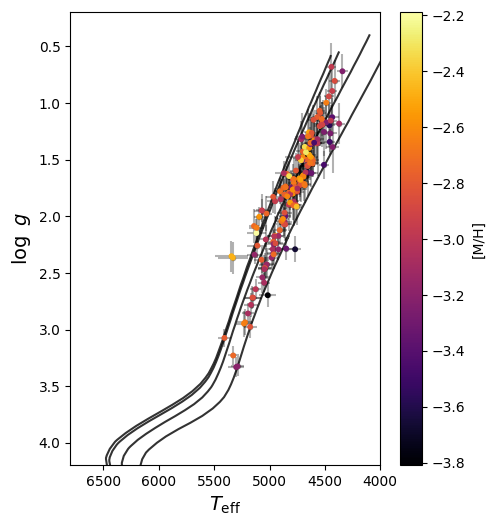

In [24]:
plt.figure(figsize=(5,6), dpi=100)

plt.errorbar(uves.teff.values, uves.logg.values, xerr=scale_factor_teff * uves.eteff_sme.values, yerr=scale_factor_logg * uves.elogg_sme.values, fmt='k.', zorder=0, alpha=0.3)
plt.scatter(uves.teff.values, uves.logg.values, s=10, c=uves.monh.values, cmap=plt.cm.inferno)

plt.colorbar(label='[M/H]')

plt.plot(10**parsec_1p0.logTe.values, parsec_1p0.logg.values, color='k', zorder=0, alpha=0.8)
plt.plot(10**parsec_1p5.logTe.values, parsec_1p5.logg.values, color='k', zorder=0, alpha=0.8)
plt.plot(10**parsec_2p0.logTe.values, parsec_2p0.logg.values, color='k', zorder=0, alpha=0.8)
plt.plot(10**parsec_2p5.logTe.values, parsec_2p5.logg.values, color='k', zorder=0, alpha=0.8)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel(r'$T_{\rm eff}$', size=14)
plt.ylabel(r'$\log\ g$', size=14)

plt.ylim(4.2, 0.2)
plt.xlim(6800, 4000)

plt.show()

In [25]:
#Save atm parameters and scaled uncs

In [28]:
uves.to_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs.csv', header=True, index=False)

In [18]:
#Save Georges file to derive ages

In [28]:
from astropy.coordinates import SkyCoord
from astroquery.vizier import Vizier
import astropy.units as u

In [29]:
atm = pd.read_csv('tmp_merged/UVES_atm.csv')
uves = pd.read_csv('uves_p111_p112_pristinedr1_xgboost_logg.csv')
uves = uves.merge(right=atm, right_on='spec_id', left_on='spec_id')

In [30]:
uves_skycoord = SkyCoord(ra=uves.ra.values * u.deg, dec=uves.dec.values * u.deg)

In [46]:
uves_2mass = Vizier(row_limit=1).query_region(catalog='II/246/out', radius=10*u.arcsec, coordinates=uves_skycoord)[0].to_pandas()[['Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag']]
uves_2mass.rename(columns={'Jmag':'j', 'e_Jmag':'ej', 'Hmag':'h', 'e_Hmag':'eh', 'Kmag':'k', 'e_Kmag':'ek'}, inplace=True)

In [47]:
uves['j'] = uves_2mass.j.values
uves['ej'] = uves_2mass.ej.values
uves['h'] = uves_2mass.h.values
uves['eh'] = uves_2mass.eh.values
uves['k'] = uves_2mass.k.values
uves['ek'] = uves_2mass.ek.values

In [48]:
ages_uves = uves[['source_id', 'spec_id', 'ra', 'dec', 'g0', 'eg', 'bp0', 'ebp', 'rp0', 'erp', 
                  'teff', 'eteff_sme', 'logg', 'elogg_sme', 'monh', 'emonh_sme', 'rpgeo', 'b_rpgeo', 'B_rpgeo',
                  'j', 'ej', 'h', 'eh', 'k', 'ek']]
ages_uves['eteff_sme'] = ages_uves.eteff_sme.values * scale_factor_teff
ages_uves['elogg_sme'] = ages_uves.elogg_sme.values * scale_factor_logg
ages_uves['emonh_sme'] = ages_uves.emonh_sme.values * scale_factor_monh
ages_uves.to_csv('UVES_ages_28102024.csv', header=True, index=False)

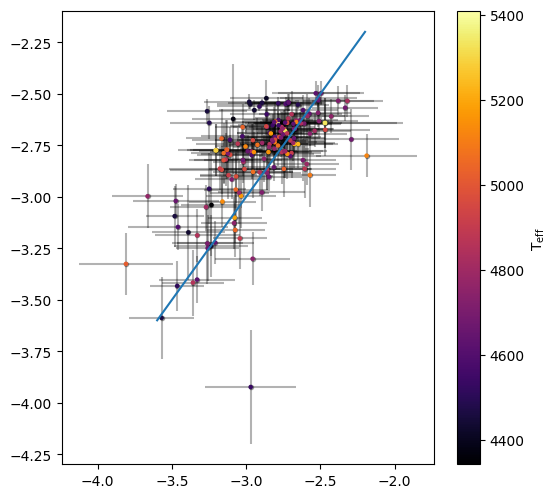

In [27]:
plt.figure(figsize=(6,6), dpi=100)

plt.scatter(uves.monh.values, uves.FeH_CaHKsyn_50th.values, c=uves.teff.values, s=5, cmap=plt.cm.inferno)
plt.colorbar(label=r'T$_{\rm eff}$')
plt.errorbar(uves.monh.values, uves.FeH_CaHKsyn_50th.values, xerr=uves.emonh_sme.values, yerr=(uves.FeH_CaHKsyn_84th.values - uves.FeH_CaHKsyn_16th.values)/2., fmt='k.', alpha=0.3, zorder=0)
x = np.linspace(-3.6, -2.2)
#FeH_CaHKsyn,FeH_CaHKsyn_16th,FeH_CaHKsyn_84th
# x = np.linspace(4400, 5400)
plt.plot(x, x)
plt.show()

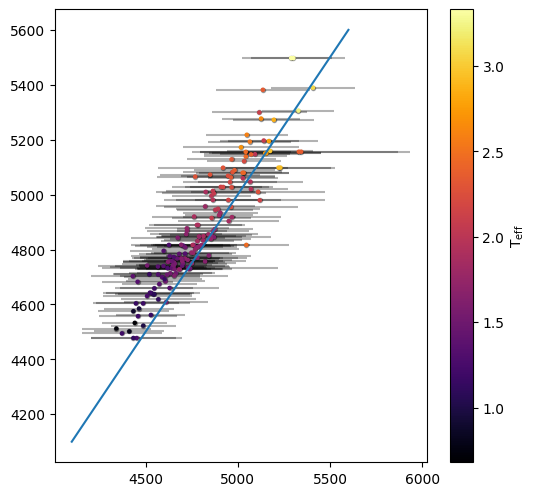

In [28]:
plt.figure(figsize=(6,6), dpi=100)

plt.scatter(uves.teff.values, uves.teff_xgboost.values, c=uves.logg.values, s=5, cmap=plt.cm.inferno)
plt.colorbar(label=r'T$_{\rm eff}$')
plt.errorbar(uves.teff.values, uves.teff_xgboost.values, xerr=uves.eteff_sme.values, fmt='k.', alpha=0.3, zorder=0)
x = np.linspace(4100, 5600)
#FeH_CaHKsyn,FeH_CaHKsyn_16th,FeH_CaHKsyn_84th
# x = np.linspace(4400, 5400)
plt.plot(x, x)
plt.show()

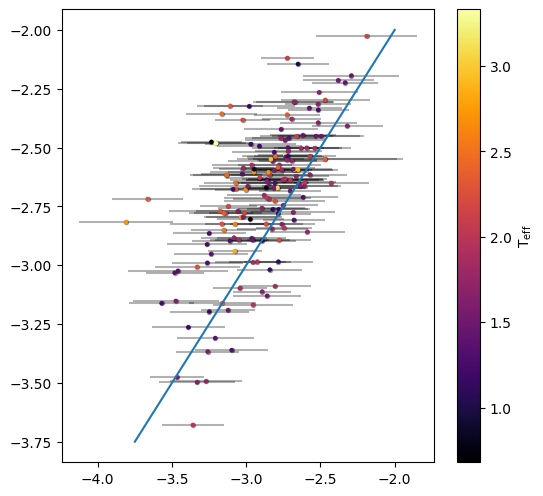

In [29]:
plt.figure(figsize=(6,6), dpi=100)

plt.scatter(uves.monh.values, uves.mh_xgboost.values, c=uves.logg.values, s=5, cmap=plt.cm.inferno)
plt.colorbar(label=r'T$_{\rm eff}$')
plt.errorbar(uves.monh.values, uves.mh_xgboost.values, xerr=uves.emonh_sme.values, fmt='k.', alpha=0.3, zorder=0)
x = np.linspace(-3.75, -2.0)
#FeH_CaHKsyn,FeH_CaHKsyn_16th,FeH_CaHKsyn_84th
# x = np.linspace(4400, 5400)
plt.plot(x, x)
plt.show()

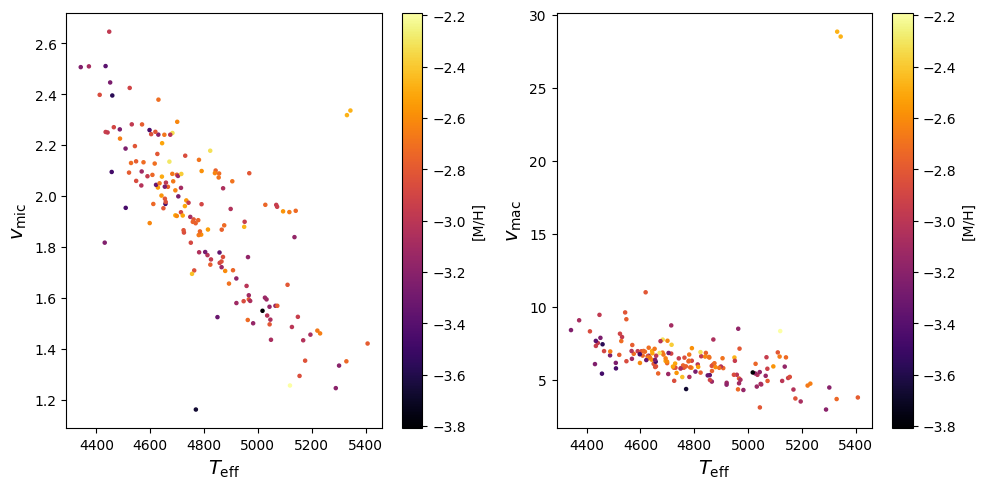

In [30]:
plt.figure(figsize=(10,5), dpi=100)

plt.subplot(1,2,1)

plt.scatter(uves.teff.values, uves.vmic.values, c=uves.monh.values, s=5, cmap=plt.cm.inferno)
plt.colorbar(label='[M/H]')
# plt.errorbar(uves.teff.values, uves.vmic.values, fmt='k.', xerr=uves.eteff_sme.values, yerr=uves.evmic_sme.values, alpha=0.3, zorder=0)

plt.xlabel(r'$T_{\rm eff}$', size=14)
plt.ylabel(r'$v_{\rm mic}$', size=14)

plt.subplot(1,2,2)

plt.scatter(uves.teff.values, uves.vmac.values, c=uves.monh.values, s=5, cmap=plt.cm.inferno)
plt.colorbar(label='[M/H]')
# plt.errorbar(uves.teff.values, uves.vmac.values, fmt='k.', xerr=uves.eteff_sme.values, yerr=uves.evmac_sme.values, alpha=0.3, zorder=0)

plt.xlabel(r'$T_{\rm eff}$', size=14)
plt.ylabel(r'$v_{\rm mac}$', size=14)

# plt.ylim(0, 10)

plt.tight_layout()
plt.show()

In [124]:
sme = SME_Structure.load('sme_save/atm_6859555838257273600_3573691_115.sme')
# sme = SME_Structure.load('tests/atm_111.251N.001_1166634514845213568_000.sme')

[2024-10-23 11:47:20,760] [INFO] [sme:load:839]: Loading SME file sme_save/atm_6859555838257273600_3573691_115.sme


INFO - Loading SME file sme_save/atm_6859555838257273600_3573691_115.sme


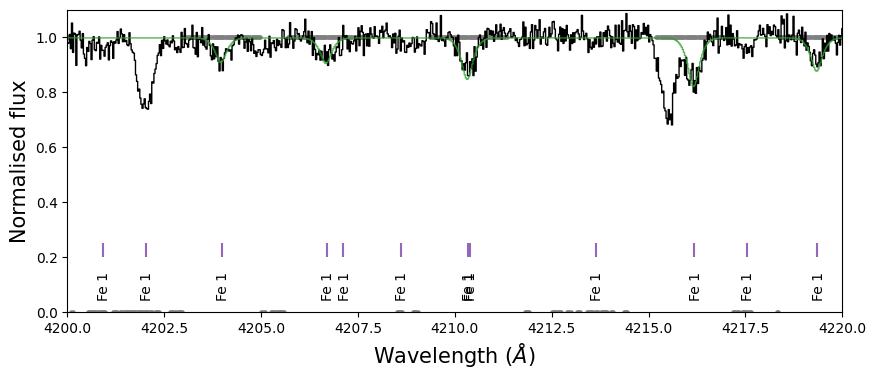

In [146]:
plt.figure(figsize=(10,4), dpi=100)
plt.step(sme.wave.data, sme.spec.data, lw=1, color='k')
plt.step(sme.wave.data, sme.synth.data, color='C2', lw=1, alpha=0.8)

for wline, species, depth in linelist[['wlcent', 'species', 'depth']]:
    if 'H 1' in species:
        continue
    # if (depth > 0.85) | (depth < 0.15):
    #     continue
    plt.vlines(wline, 0.2, 0.25, color='C4')
    plt.annotate(text='%s' %species, xy=(wline-0.15, 0.05), rotation=90)
    # plt.annotate(text='%2.3f' %depth, xy=(wline-0.15, 0.5), rotation=90)
    
plt.scatter(sme.wave.data, sme.mask.data, color='grey', s=5)

plt.xlabel(r'Wavelength ($\AA$)', size=15)
plt.ylabel(r'Normalised flux', size=15)

# plt.xlim(4025, 4035)
# plt.xlim(4270, 4320)
plt.xlim(4200, 4220)
# plt.xlim(4125, 4135)
# plt.xlim(4172, 4190)
# plt.xlim(4220, 4240)
# plt.xlim(4460, 4470)
# plt.xlim(4850, 4870)
# plt.xlim(5165, 5190)
# plt.xlim(5167, 5172)
# plt.xlim(5188, 5199)
# plt.xlim(5885, 5900)
# plt.xlim(6550, 6570)
# plt.hlines(1, 4125, 4132)
plt.ylim(0.0, 1.1)
plt.show()

In [5]:
#Continuum model in the SME format

In [6]:
cont_blue = ispec.read_continuum_regions('continuum_model/continuum_regions_blue.txt')
cont_blue2 = ispec.read_continuum_regions('continuum_model/continuum_regions_blue2.txt')
cont_red1 = ispec.read_continuum_regions('continuum_model/continuum_regions_red1.txt')
cont_red2 = ispec.read_continuum_regions('continuum_model/continuum_regions_red2.txt')

In [8]:
wmin_blue = 4000 #AA
wmax_blue = 4500 #AA

wmin_blue2 = 3300 #AA
wmax_blue2 = 3900 #AA

wmin_red1 = 4730 #AA
wmax_red1 = 5700 #AA
wmin_red2 = 5850 #AA
wmax_red2 = 6800 #AA

In [9]:
blue_spec = ispec.read_spectrum('norm_RV_corr/111.251N.001/blue_ADP.2023-04-24T10:49:45.001.fits')
blue_spec.waveobs = blue_spec.waveobs
blue2_spec = ispec.read_spectrum('norm_RV_corr/111.251N.001/blue2_ADP.2023-04-24T10:49:45.001.fits')
blue2_spec.waveobs = blue2_spec.waveobs
red1_spec = ispec.read_spectrum('norm_RV_corr/111.251N.001/red1_ADP.2023-04-24T10:49:45.012.fits')
red1_spec.waveobs = red1_spec.waveobs
red2_spec = ispec.read_spectrum('norm_RV_corr/111.251N.001/red2_ADP.2023-04-24T10:49:45.012.fits')
red2_spec.waveobs = red2_spec.waveobs

In [10]:
sme = SME_Structure.load('sme_save/atm_6425379106130933376_3573700_088.sme')

[2024-06-25 09:56:20,265] [INFO] [sme:load:839]: Loading SME file sme_save/atm_6425379106130933376_3573700_088.sme


INFO - Loading SME file sme_save/atm_6425379106130933376_3573700_088.sme


In [11]:
blue2_spec.waveobs

array([330.    , 330.0028, 330.0056, ..., 389.9928, 389.9956, 389.9984])

In [12]:
%%time
#Nitrogen continuum regions
cont_mask_blue2 = np.zeros_like(blue2_spec.waveobs)

for mask_i, wl in enumerate(blue2_spec.waveobs):
    for cont_low, cont_high in cont_blue2:
        if (wl <= cont_low) | (wl >= cont_high):
            continue
        else:
            cont_mask_blue2[mask_i] = 2
            break

CPU times: user 30.1 s, sys: 0 ns, total: 30.1 s
Wall time: 30.2 s


In [13]:
%%time

cont_mask_blue = np.zeros_like(sme.wave[0])

for mask_i, wl in enumerate(sme.wave[0]/10.):
    for cont_low, cont_high in cont_blue:
        if (wl <= cont_low) | (wl >= cont_high):
            continue
        else:
            cont_mask_blue[mask_i] = 2
            break
            
cont_mask_red1 = np.zeros_like(sme.wave[1])

for mask_i, wl in enumerate(sme.wave[1]/10.):
    for cont_low, cont_high in cont_red1:
        if (wl <= cont_low) | (wl >= cont_high):
            continue
        else:
            cont_mask_red1[mask_i] = 2
            break
            
cont_mask_red2 = np.zeros_like(sme.wave[2])

for mask_i, wl in enumerate(sme.wave[2]/10.):
    for cont_low, cont_high in cont_red2:
        if (wl <= cont_low) | (wl >= cont_high):
            continue
        else:
            cont_mask_red2[mask_i] = 2
            break

CPU times: user 44.8 s, sys: 767 µs, total: 44.8 s
Wall time: 44.9 s


In [14]:
cont_mask_all = np.concatenate([cont_mask_blue, cont_mask_red1, cont_mask_red2])
wl_mask_all = sme.wave.data

In [24]:
np.savetxt('continuum_model/sme_cont_mask_blue', np.column_stack((sme.wave[0], cont_mask_blue)), fmt=['%f', '%d'])
np.savetxt('continuum_model/sme_cont_mask_red1', np.column_stack((sme.wave[1], cont_mask_red1)), fmt=['%f', '%d'])
np.savetxt('continuum_model/sme_cont_mask_red2', np.column_stack((sme.wave[2], cont_mask_red2)), fmt=['%f', '%d'])

np.savetxt('continuum_model/sme_cont_mask', np.column_stack((wl_mask_all, cont_mask_all)), fmt=['%f', '%d'])

In [25]:
np.savetxt('continuum_model/sme_cont_mask_blue2', np.column_stack((blue2_spec.waveobs*10., cont_mask_blue2)), fmt=['%f', '%d'])